# Exercise 1a
#### Lars Kühmichel, Ergin Kohen Sagner, Nico Wolf

## 1 Monte-Carlo Simulation
### 1.1 Data Creation and Visualization
#### Inverse Transform Sampling
For $Y = 1$, it holds that $P(X = x) = 2x$. The CDF for $P$ is given as
$CDF(X \leq x) = \int_0^x 2x' \,dx' = x^2$.
With Inverse Transform Sampling, $X$ is then given by $CDF^{-1}(u) = \sqrt{u}$ where $u$ is
sampled from a uniform distribution in the interval $[0, 1]$.

For $Y = 0$, it holds that $P(x = x) = 2 - 2x$. The CDF for $P$ is then
$CDF(X \leq x) = \int_0^x 2 - 2x' \, dx' = 2x - x^2$. Analogously, $X$ is then given by $1 - \sqrt{1 - u}$.

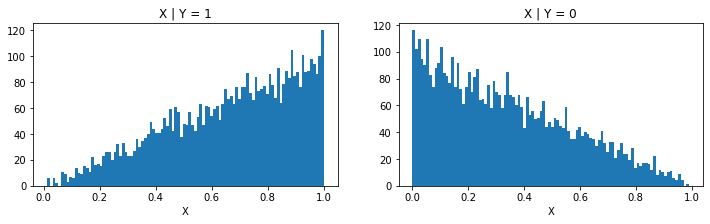

In [139]:
import numpy as np
from uncertainties import ufloat
from matplotlib import pyplot as plt


def create_data(N):
    # randint is high exclusive
    labels = np.random.randint(0, 2, size=N).astype(bool)

    features = np.random.uniform(0, 1, size=N)
    features = np.where(labels, np.sqrt(features), 1 - np.sqrt(1 - features))

    return features, labels

n = 10000

x, y = create_data(n)

# verify x and y are created correctly
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].hist(x[y], bins=100)
axes[0].set_title("X | Y = 1")
axes[0].set_xlabel("X")
axes[1].hist(x[~y], bins=100)
axes[1].set_title("X | Y = 0")
axes[1].set_xlabel("X")
plt.show()

### 1.2 Classification by Thresholding

We have experimentally confirmed the error rates, including the minimum at $x_t = 0.5$. From the results, it can be presumed that the standard deviation in the error decreases with $\frac{1}{\sqrt{M}}$,
since multiplying $M$ by $10$ roughly divides the standard deviation by $3$.
This coincides with theoretical expectations of such.

In [140]:
class ClassifierTest:
    def __init__(self, data_creator, classifier):
        """
        Classifier Test Class
        :param data_creator: Callable that returns features and labels
        :param classifier: Callable that takes features and returns guesses for labels
        """
        self.data_creator = data_creator
        self.classifier = classifier

    def run(self, iterations, creator_args=None, creator_kwargs=None, classifier_args=None, classifier_kwargs=None):
        if creator_args is None:
	        creator_args = []
        if creator_kwargs is None:
	        creator_kwargs = {}
        if classifier_args is None:
            classifier_args = []
        if classifier_kwargs is None:
            classifier_kwargs = {}

        errors = []

        for _ in range(iterations):
            features, labels = self.data_creator(*creator_args, **creator_kwargs)

            classified = self.classifier(features, *classifier_args, **classifier_kwargs)

            incorrect = classified != labels

            error = np.mean(incorrect.astype(float))

            errors.append(error)

        return np.array(errors), np.mean(errors), np.std(errors)

def tc(x, x_t):
    return x >= x_t

def tac(x, x_t):
    return x < x_t

for x_t in [0.2, 0.5, 0.6]:
    print("=========================")
    print(f"x_t = {x_t}")
    print("=========================")
    for M in [10, 100, 1000, 10_000]:
        predicted_error_tc = 0.25 + (x_t - 0.5) ** 2
        predicted_error_tac = 1 - predicted_error_tc

        tc_test = ClassifierTest(create_data, tc)
        tac_test = ClassifierTest(create_data, tac)

        errors_tc, mean_tc, std_tc = tc_test.run(
            iterations=10,
            creator_args=[M],
            creator_kwargs=None,
            classifier_args=[x_t],
            classifier_kwargs=None
        )

        errors_tac, mean_tac, std_tac = tac_test.run(
            iterations=10,
            creator_args=[M],
            creator_kwargs=None,
            classifier_args=[x_t],
            classifier_kwargs=None
        )

        # pretty printing
        print(f"M = {M}")
        print(f"Expected Error TC = {predicted_error_tc:.2f}")
        print(f"Actual Error TC = {ufloat(mean_tc, std_tc)}")
        print(f"Expected Error TAC = {predicted_error_tac}")
        print(f"Actual Error TAC = {ufloat(mean_tac, std_tac)}")
        print()

x_t = 0.2
M = 10
Expected Error TC = 0.34
Actual Error TC = 0.31+/-0.17
Expected Error TAC = 0.66
Actual Error TAC = 0.78+/-0.09

M = 100
Expected Error TC = 0.34
Actual Error TC = 0.336+/-0.029
Expected Error TAC = 0.66
Actual Error TAC = 0.65+/-0.05

M = 1000
Expected Error TC = 0.34
Actual Error TC = 0.337+/-0.017
Expected Error TAC = 0.66
Actual Error TAC = 0.655+/-0.013

M = 10000
Expected Error TC = 0.34
Actual Error TC = 0.342+/-0.004
Expected Error TAC = 0.66
Actual Error TAC = 0.661+/-0.006

x_t = 0.5
M = 10
Expected Error TC = 0.25
Actual Error TC = 0.24+/-0.10
Expected Error TAC = 0.75
Actual Error TAC = 0.78+/-0.13

M = 100
Expected Error TC = 0.25
Actual Error TC = 0.263+/-0.018
Expected Error TAC = 0.75
Actual Error TAC = 0.752+/-0.029

M = 1000
Expected Error TC = 0.25
Actual Error TC = 0.239+/-0.015
Expected Error TAC = 0.75
Actual Error TAC = 0.744+/-0.010

M = 10000
Expected Error TC = 0.25
Actual Error TC = 0.2514+/-0.0032
Expected Error TAC = 0.75
Actual Error TAC =

### 1.3 Baseline Classifiers

We can confirm the expected error rate of $50\%$.

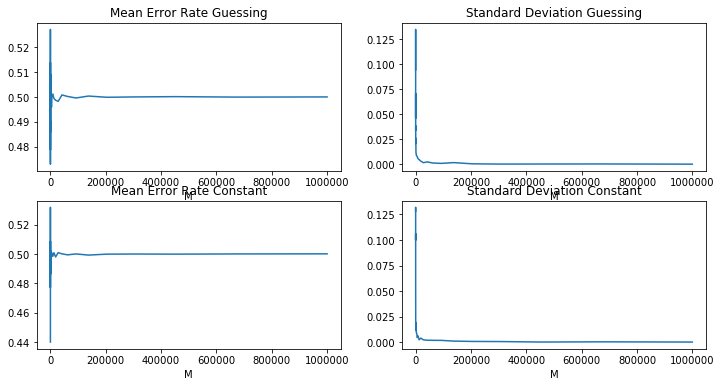

In [141]:
def guessing(x):
    return np.random.choice([True, False], size=x.shape)

def constant(x):
    return np.ones_like(x).astype(bool)

Ms = np.logspace(1, 6, 30, dtype=int)
means_g = []
stds_g = []
means_c = []
stds_c = []

for M in Ms:
    guessing_test = ClassifierTest(create_data, guessing)
    constant_test = ClassifierTest(create_data, constant)

    errors_g, mean_g, std_g = guessing_test.run(
        iterations=10,
        creator_args=[M],
        creator_kwargs=None,
        classifier_args=None,
        classifier_kwargs=None
    )

    errors_c, mean_c, std_c = constant_test.run(
        iterations=10,
        creator_args=[M],
        creator_kwargs=None,
        classifier_args=None,
        classifier_kwargs=None
    )

    # print(f"M = {M}")
    # print(f"Error Guessing = {ufloat(mean_g, std_g)}")
    # print(f"Error Constant = {ufloat(mean_c, std_c)}")

    means_g.append(mean_g)
    stds_g.append(std_g)

    means_c.append(mean_c)
    stds_c.append(std_c)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes[0][0].plot(Ms, means_g)
axes[0][0].set_title("Mean Error Rate Guessing")
axes[0][1].plot(Ms, stds_g)
axes[0][1].set_title("Standard Deviation Guessing")
axes[1][0].plot(Ms, means_c)
axes[1][0].set_title("Mean Error Rate Constant")
axes[1][1].plot(Ms, stds_c)
axes[1][1].set_title("Standard Deviation Constant")

for row in axes:
    for ax in row:
        ax.set_xlabel("M")

plt.show()


